# 1. Importing basic libraries and the dataset

In [27]:
# Basic libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [28]:
# Load the dataset
df = pd.read_csv('train.csv')
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [29]:
# Check the datatypes of each column
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

## Since we have categorical variables, we need to handle them in the preprocessing stage.

# 2. Data cleaning

In [30]:
# Remove the column for ID
ids = df['Id']
df.drop('Id', axis=1, inplace=True)

In [31]:
# Fill the empty numerical data with 0
for col in df.columns:
    if df[col].dtype != 'object':
        df[col] = df[col].fillna(0)

In [32]:
df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 3. Converting categorical values into numerical values with one-hot encoding

In [33]:
# Obtain categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()

# One-hot encoding for categorical columns (inputs)
df1 = pd.get_dummies(df, columns=cat_cols, dummy_na=True)

In [34]:
# Check dataset structure to confirm that one-hot encoding has been applied
print(df1.head(5))

   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_Oth  \
0          2003       196.0         706           0  ...         False   
1          1976         0.0         978           0  ...         False   
2          2002       162.0         486           0  ...         False   
3          1970         0.0         216           0  ...         False   
4          2000       350.0         655           0  ...         False   

   SaleType_WD  SaleType_nan  SaleCondition_Abnorml  SaleCondition_AdjLand  \
0         True      

# 4. Training the random forest model

In [35]:
# Separate features and target
X = df1.drop('SalePrice', axis=1)
y = np.log1p(df1['SalePrice'])

# Split into train and validation sets
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids, test_size=0.2, random_state=42
)

In [36]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=30, n_jobs=-1)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=30),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [11]:
# Output the best parameters found during the grid search
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


# 5. Using Random Forest to estimate the saleprice

In [12]:
def evaluate_rmse(model, X_test, y_test):
    """
    Evaluates RMSE on original SalePrice scale.
    
    Parameters:
        model : trained regression model
        X_test : validation features
        y_test : log-transformed target values
    
    Returns:
        rmse : float
        y_test_actual : ndarray
        y_pred : ndarray
    """
    # Predict in log scale
    y_pred_log = model.predict(X_test)
    
    # Convert back to original scale
    y_pred = np.expm1(y_pred_log)
    y_test_actual = np.expm1(y_test)
    
    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    
    return rmse, y_test_actual, y_pred

In [13]:
def plot_actual_vs_predicted(y_actual, y_pred, model_name="Model"):
    """
    Plots Actual vs Predicted SalePrice sorted by actual values.
    
    Parameters:
        y_actual : array-like (original scale)
        y_pred : array-like (original scale)
        model_name : str
    """
    # Sort by actual prices
    order = np.argsort(y_actual.values if hasattr(y_actual, "values") else y_actual)
    
    y_actual_sorted = y_actual.values[order] if hasattr(y_actual, "values") else y_actual[order]
    y_pred_sorted = y_pred[order]
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_actual_sorted, label="Actual SalePrice", linewidth=2)
    plt.plot(y_pred_sorted, label=f"Predicted SalePrice ({model_name})", alpha=0.8)
    
    plt.xlabel("Sorted Index (by Actual Price)")
    plt.ylabel("SalePrice")
    plt.title(f"Actual vs Predicted SalePrice ({model_name})")
    plt.legend()
    plt.show()

In [14]:
# Fit the test data into the model
rf_model = grid_search.best_estimator_
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=30)

In [15]:
# Evaluate
rf_rmse, y_actual, rf_pred = evaluate_rmse(rf_model, X_test, y_test)
print("Random Forest RMSE:", rf_rmse)

Random Forest RMSE: 29956.825365304125


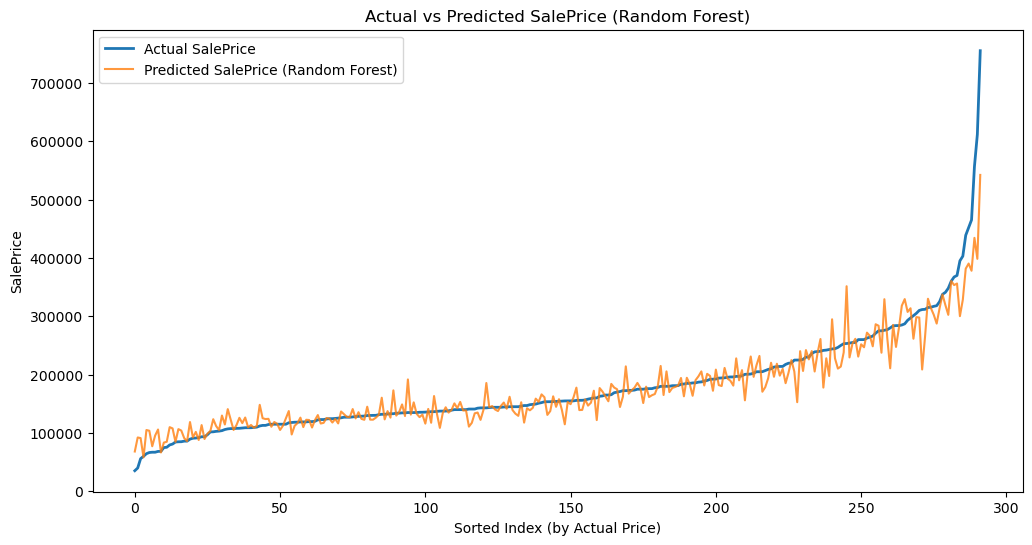

In [16]:
# Plot
plot_actual_vs_predicted(y_actual, rf_pred, model_name="Random Forest")

# 6. Using XGBoost to estimate the saleprice

In [17]:
# Set up the algorithm for XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)
print("Best XGBoost parameters:", grid_search_xgb.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best XGBoost parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}


In [21]:
best_xgb_model = grid_search_xgb.best_estimator_
xgb_rmse, y_test_actual_xgb, y_test_pred_xgb = evaluate_rmse(
    model=best_xgb_model,
    X_test=X_test,
    y_test=y_test
)

print(f"XGBoost RMSE (original scale): {xgb_rmse:,.2f}")


XGBoost RMSE (original scale): 27,298.27


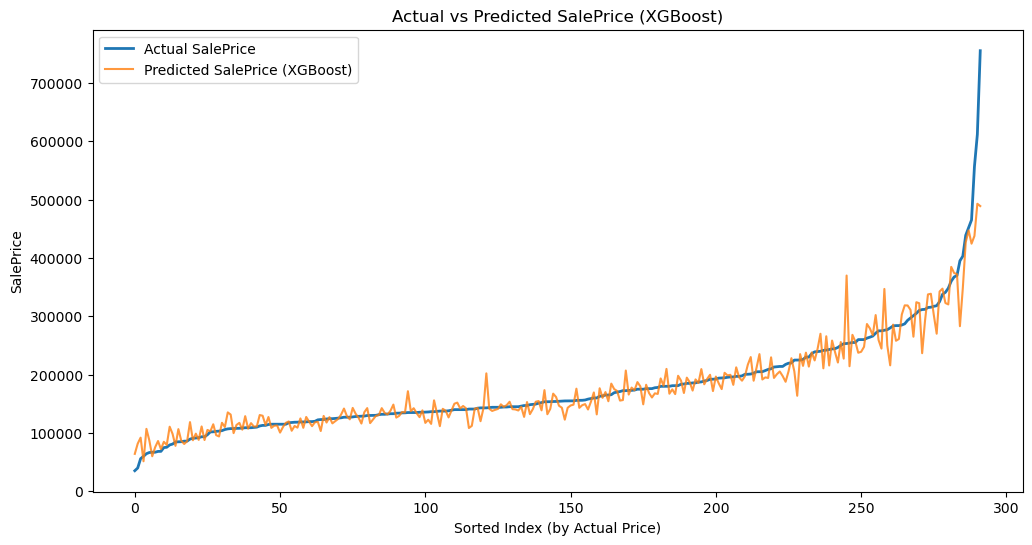

In [22]:
plot_actual_vs_predicted(
    y_actual=y_test_actual_xgb,
    y_pred=y_test_pred_xgb,
    model_name="XGBoost"
)


# 7. Using Bagging to estimate the saleprice

In [24]:
# Set up the algorithm for bagging
bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    random_state=42,
    n_jobs=-1
)

param_grid_bag = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.7, 0.8, 1.0],
    'max_features': [0.7, 0.8, 1.0],
    'bootstrap': [True, False]
}

grid_search_bag = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid_bag,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search_bag.fit(X_train, y_train)
print("Best Bagging parameters:", grid_search_bag.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Bagging parameters: {'bootstrap': False, 'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 100}


In [25]:
best_bag_model = grid_search_bag.best_estimator_
bag_rmse, y_test_actual_bag, y_test_pred_bag = evaluate_rmse(
    model=best_bag_model,
    X_test=X_test,
    y_test=y_test
)

print(f"Bagging RMSE (original scale): {bag_rmse:,.2f}")


Bagging RMSE (original scale): 30,537.70


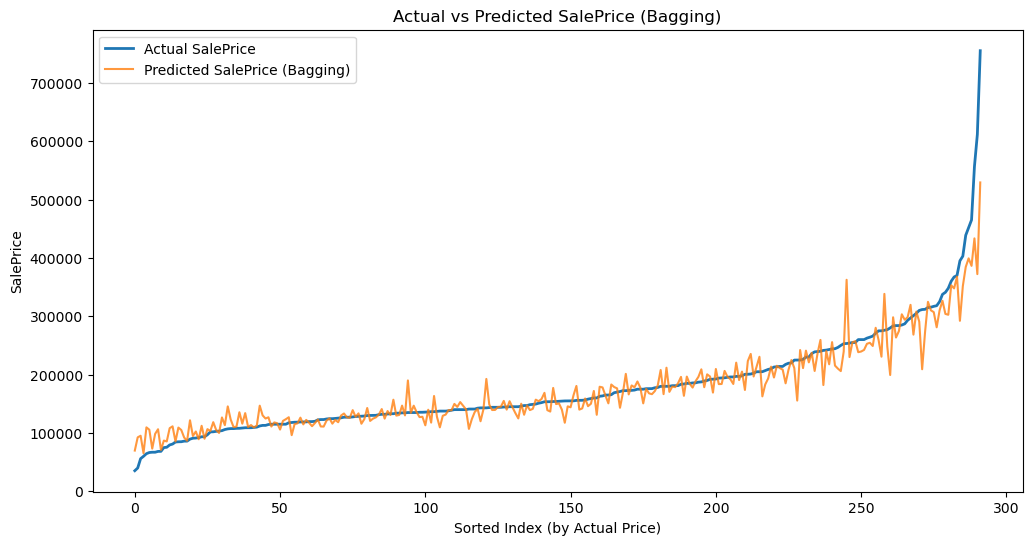

In [26]:
plot_actual_vs_predicted(
    y_actual=y_test_actual_bag,
    y_pred=y_test_pred_bag,
    model_name="Bagging"
)

### Among the evaluated models, XGBoost achieved the lowest RMSE, indicating superior predictive accuracy compared to Random Forest and Bagging. This performance advantage can be attributed to XGBoost’s boosting framework, which sequentially corrects residual errors and effectively captures complex non-linear relationships in the data. The results suggest that boosting-based ensemble methods outperform bagging-based approaches for this dataset, making XGBoost the most suitable model for house price estimation in this project.